# Filtering and loading the issues to Google Spreadsheets

In [3]:
import json
import pandas as pd
import pygsheets
import re

In [4]:
# Load JSON file containing the RAW data mined with Perceval.
with open('terraform_issues_updated.json', 'r') as f:
  data = json.load(f)

In [5]:
len(data['repositories'])

578

In [7]:
# Keywords used for filtering
keywords = {'cost', 'cheap', 'pay', 'bill', 'expens', 'efficient'}

In [8]:
# Regex based functions that looks up 12 words before and after one of the cost keywords defined above.
def search(keyword, text):
    m = re.search(r'((?:\w+\W+){{,12}})(\w*{lookup_word}\w*)\W*((?:\w+\W+){{,12}})'.format(lookup_word=keyword), text)
    l = None
    if m:
        l = [ x.strip().split() for x in m.groups()]
    if l is None:
        return "" 
    left, right = l[0], l[2]
    return " ".join(left)+" "+l[1][0]+" "+" ".join(right)

In [7]:
# Filter out the Pull Request from the RAW data.
issues_list = []

for repo in data["repositories"]:
    for issue in repo["issues"]:
        if issue["category"] != "pull_request":
            issues_list.append(issue)
    

In [8]:
# Save the issues that we remove in case we want to access later.
removed_list_issues = []
# Filtered issues to be manually labeled.
filtered_list_issues = []
# Created a set that holds the body of all issues to check in case of duplicates (generated by bots for example).
text_set = set()

# Loop through all the issues and concatenate their title, body and comments into 1 field.
for issue in issues_list:
    issue_text = issue['title']
    if issue['body'] is not None:
        issue_text = issue_text + '\n' + issue['body']
    if issue['comments_data'] is not None:
        for comment in issue['comments_data']:
            if comment['body'] is not None:
                issue_text = issue_text + '\n' + comment['body']

    if issue_text not in text_set:
        new_body = ""
        flag = False
        # Add a keyword fields that will automatically be filled in.
        issue["keyword"] = ""
        # For each cost keyword we have
        for key in keywords:
            # Use our regex function to search 12 words around the keyword if it exists in the body.
            snippet = search(key, issue_text)
            if snippet == "":
                continue
            new_body = new_body + snippet + ".\n"
            # Add the issue to the set and re-write its body with the regex output.
            text_set.add(issue_text)
            issue['body'] = new_body
            if issue["keyword"] == "":
                issue["keyword"] = key
            flag = True
        # In case there none of the keywords appear. It should not happen as we already filtered on them.    
        if flag:    
            filtered_list_issues.append(issue)
        else:
            print(issue['html_url'])
    # If the issue body was already found in the set.
    else:
        print("!!!!!!!!!")
        print(issue['html_url'])
        print("!!!!!!!!!")
        removed_list_issues.append(issue)

!!!!!!!!!
https://github.com/B-R-H/Final_project/issues/3
!!!!!!!!!


In [44]:
# Example of how to use the regex search function.
search('pay', "Console registry from 3.x release is no longer included in the release payload")

'registry from 3.x release is no longer included in the release payload test.'

In [10]:
# Convert he python dictionary to a Pandas dataframe to write to the Google Spreadsheets.
issues_df = pd.DataFrame(filtered_list_issues)
issues_df

,title,html_url,user,category,labels,closed_at,assignee,assignees,body,comments,comments_data,keyword
0,Use azure pricing calculator to estimate cost ...,https://github.com/B-R-H/Final_project/issues/4,https://api.github.com/users/MattCrutchley,issue,[],2020-04-17T09:02:53Z,None,[],Use azure pricing calculator to estimate cost ...,0,[],cost
1,Payments service missing in consul service mes...,https://github.com/hashicorp/learn-consul-kube...,https://api.github.com/users/ChanderG,issue,[],None,None,[],tutorial itself does not cover the app functio...,0,[],pay
2,Consider using long loadbalancer connection ti...,https://github.com/coreos/tectonic-installer/i...,https://api.github.com/users/aaronlevy,issue,"[{'id': 557217031, 'node_id': 'MDU6TGFiZWw1NTc...",2017-05-17T15:16:05Z,"{'login': 's-urbaniak', 'id': 375856, 'node_id...","[{'login': 's-urbaniak', 'id': 375856, 'node_i...",relist of all the watched objects and this cou...,3,[{'url': 'https://api.github.com/repos/coreos/...,expens
3,Service IP addresses should use `cidrhost(tect...,https://github.com/coreos/tectonic-installer/i...,https://api.github.com/users/ggreer,issue,[],2017-05-19T14:29:11Z,"{'login': 's-urbaniak', 'id': 375856, 'node_id...","[{'login': 's-urbaniak', 'id': 375856, 'node_i...",com/notifications/unsubscribe-auth/AANr3lRykwZ...,5,[{'url': 'https://api.github.com/repos/coreos/...,pay
4,Update TCO version to 0.3.3,https://github.com/coreos/tectonic-installer/i...,https://api.github.com/users/diegs,issue,[],2017-05-24T06:22:23Z,"{'login': 'diegs', 'id': 74719, 'node_id': 'MD...","[{'login': 'diegs', 'id': 74719, 'node_id': 'M...",3.3 We need TCO 0.3.3 to enforce signing of pa...,0,[],pay
...,...,...,...,...,...,...,...,...,...,...,...,...
856,[Feature Request] Improve detection of parent-...,https://github.com/ExpediaDotCom/haystack/issu...,https://api.github.com/users/worldtiki,issue,"[{'id': 658537864, 'node_id': 'MDU6TGFiZWw2NTg...",None,None,[],"primary concern. So, A top-level remote servic...",13,[{'url': 'https://api.github.com/repos/Expedia...,efficient
857,Route53 type CNAME?,https://github.com/Guimove/terraform-aws-basti...,https://api.github.com/users/ryanli-me,issue,[],2018-10-23T14:47:17Z,None,[],bastion elb. Maybe type 'A' with alias should ...,2,[{'url': 'https://api.github.com/repos/Guimove...,cheap
858,please consider using launch template in place...,https://github.com/Guimove/terraform-aws-basti...,https://api.github.com/users/rverma-nikiai,issue,"[{'id': 824733579, 'node_id': 'MDU6TGFiZWw4MjQ...",2020-03-18T13:13:05Z,None,[],either with an autoscaling group behind nlb or...,0,[],cost
859,[Feature request] Dynamic-latest AMI support f...,https://github.com/Guimove/terraform-aws-basti...,https://api.github.com/users/eratio08,issue,[],None,None,[],would be really great if the new `t4g` instanc...,0,[],cheap


In [14]:
# For the manual labeling we do not need all these extra columns so we drop them.
issues_df.drop(['user', 'category', 'labels', 'closed_at', 'assignee', 'assignees', 'comments', 'comments_data'], axis = 1, inplace=True)
issues_df

,title,html_url,body
0,Use azure pricing calculator to estimate cost ...,https://github.com/B-R-H/Final_project/issues/3,


In [13]:
# Save the removed issues in case we have time to look into them.
issues_df = pd.DataFrame(removed_list_issues)

In [2]:
# Write the data to the our Google Spreadsheets. This step will not work for third-parties, but we do provide the local 
# CSV file.

# authorization
gc = pygsheets.authorize(service_file='commitevalutaion-6a3c4370bf89.json')
# open the google spreadsheet (where 'PY to Gsheet Test' is the name of my sheet)
sh = gc.open('Terraform data analysis')
# select the first sheet
wks = sh[7]
# update the first sheet with df, starting at cell B2.
wks.set_dataframe(issues_df, (863, 1))

# Generating statistics based on the labeled issues

In [1]:
import pygsheets
import pandas as pd
import numpy as np

In [2]:
# To use this code block you need to change the service_file to one that has access to the file. Otherwise load the local file.

# access the sheets and get the commit sheet
gc = pygsheets.authorize(service_file='commitevalutaion-6a3c4370bf89.json')
sheets = gc.open_by_url("https://docs.google.com/spreadsheets/d/1OYsymuoRJGAXTHQImI0ycbN2NQhsxSkqlj-W-PEHRvw/edit#gid=1782607577")
issue_sheet = sheets[1]
issue_sheet

<Worksheet 'Issue' index:1>

In [3]:
# get a dictionary of the tables
data_dic = issue_sheet.get_all_records()
print(len(data_dic))
pandas_df = pd.DataFrame(data=data_dic)
pandas_df

862


,html_url,title,body,keyword,label,,sentiment,102
0,https://github.com/B-R-H/Final_project/issues/4,Use azure pricing calculator to estimate cost ...,Use azure pricing calculator to estimate cost ...,cost,other-addition-cost_calculator,,,
1,https://github.com/hashicorp/learn-consul-kube...,Payments service missing in consul service mes...,tutorial itself does not cover the app functio...,pay,other-false_positive,,,
2,https://github.com/coreos/tectonic-installer/i...,Consider using long loadbalancer connection ti...,relist of all the watched objects and this cou...,expens,other-performance-unknown,,,
3,https://github.com/coreos/tectonic-installer/i...,Service IP addresses should use `cidrhost(tect...,com/notifications/unsubscribe-auth/AANr3lRykwZ...,pay,other-false_positive,,,
4,https://github.com/coreos/tectonic-installer/i...,Update TCO version to 0.3.3,3.3 We need TCO 0.3.3 to enforce signing of pa...,pay,other-false_positive,,,
...,...,...,...,...,...,...,...,...
857,https://github.com/Guimove/terraform-aws-basti...,Route53 type CNAME?,bastion elb. Maybe type 'A' with alias should ...,cheap,cost-saving-domain,,Positive,
858,https://github.com/Guimove/terraform-aws-basti...,please consider using launch template in place...,either with an autoscaling group behind nlb or...,cost,cost-saving-domain,,Positive,
859,https://github.com/Guimove/terraform-aws-basti...,[Feature request] Dynamic-latest AMI support f...,would be really great if the new `t4g` instanc...,cheap,cost-saving-instance,,Positive,
860,https://github.com/void-linux/void-infrastruct...,Mirror: The creation of a formal request.,then this should also be noted. Please keep in...,pay,other-false_positive,,,


In [4]:
# Filter only the relevant issues (that talk about cost management)
new_df = pandas_df[pandas_df["label"].str.contains("cost-")]
new_df

,html_url,title,body,keyword,label,,sentiment,102
15,https://github.com/coreos/tectonic-installer/i...,Terraform Modules,"identity, prometheus, heapster, and other feat...",pay,cost-awareness-billing_mode,They are wondering if it's possible to remove ...,Negative,
19,https://github.com/coreos/tectonic-installer/i...,Add Spotinst integration for worker nodes as a...,s Spot Instance market](https://aws.amazon.com...,cost,cost-saving-instance,,Positive,
21,https://github.com/ministryofjustice/modernisa...,Check billing for regional services configured...,Check billing for regional services configured...,bill,cost-awareness-billing_mode,,Positive,
23,https://github.com/ministryofjustice/modernisa...,Add S3 mount for Performance Hub,or one can be created specifically for managin...,cost,"cost-saving-provider, cost-awareness-provider",,Negative,
24,https://github.com/ministryofjustice/modernisa...,create a local sandbox transit gateway,the default route on Mod Plaformform is used f...,cost,cost-increase-networking-NAT,,Negative,
...,...,...,...,...,...,...,...,...
840,https://github.com/openshift/okd/issues/619,OKD 4.5 in AWS - Cluster did not started after...,4.5.0-0.okd-2020-10-15-235428 To save the cost...,cost,cost-saving-cluster,kindof,Positive,
855,https://github.com/ExpediaDotCom/haystack/issu...,[Feature Request] Log number of bytes sent and...,more we increase the performance of our servic...,cost,cost-saving-unknown,,Positive,
857,https://github.com/Guimove/terraform-aws-basti...,Route53 type CNAME?,bastion elb. Maybe type 'A' with alias should ...,cheap,cost-saving-domain,,Positive,
858,https://github.com/Guimove/terraform-aws-basti...,please consider using launch template in place...,either with an autoscaling group behind nlb or...,cost,cost-saving-domain,,Positive,


In [5]:
# Generate a frequency histogram for the keywords.
keyword_hist_cost = new_df["keyword"].value_counts().to_dict()
keyword_hist_cost

{'cost': 127, 'cheap': 30, 'pay': 21, 'expens': 20, 'bill': 8, 'efficient': 1}

In [6]:
# create histogram of ALL cost labels
hist_cost = {}
for index, row in new_df.iterrows():
    list_labels = row["label"].split(", ")
    for label in list_labels:
        label = label.strip("\n")
        # e.g. other-addition-module, cost-saving-NAT
        if "other-" in label:
            continue
        hist_cost[label] = hist_cost.get(label, 0) + 1
dict(sorted(hist_cost.items(), key=lambda item: -item[1]))

{'cost-awareness-feature': 31,
 'cost-awareness-storage': 28,
 'cost-saving-instance': 23,
 'cost-saving-storage': 20,
 'cost-awareness-instance': 19,
 'cost-saving-feature': 16,
 'cost-awareness-provider': 13,
 'cost-awareness-unknown': 9,
 'cost-awareness-alert': 9,
 'cost-awareness-networking-VPN': 9,
 'cost-saving-cluster': 9,
 'cost-saving-unknown': 7,
 'cost-awareness-networking-NAT': 6,
 'cost-awareness-cluster': 5,
 'cost-saving-domain': 4,
 'cost-awareness-billing_mode': 3,
 'cost-saving-networking-VPN': 3,
 'cost-increase-instance': 3,
 'cost-awareness-domain': 3,
 'cost-awareness-area': 3,
 'cost-saving-networking-NAT': 3,
 'cost-saving-provider': 2,
 'cost-increase-provider': 2,
 'cost-awareness-networking': 2,
 'cost-increase-unknown': 2,
 'cost-increase-feature': 2,
 'cost-increase-cluster': 2,
 'cost-increase-networking-NAT': 1,
 'cost-saving-billing_mode': 1,
 'const-increase-storage': 1,
 'cost-increase-networking': 1,
 'cost-increase-storage': 1,
 'cost-awareness-clus

In [7]:
# Histogram for only the cost-saving branch of our taxonomy.
hist_saving = dict(hist_cost)
for elem in hist_cost:
    if "cost-saving" not in elem:
        del hist_saving[elem]
dict(sorted(hist_saving.items(), key=lambda item: -item[1]))

{'cost-saving-instance': 23,
 'cost-saving-storage': 20,
 'cost-saving-feature': 16,
 'cost-saving-cluster': 9,
 'cost-saving-unknown': 7,
 'cost-saving-domain': 4,
 'cost-saving-networking-VPN': 3,
 'cost-saving-networking-NAT': 3,
 'cost-saving-provider': 2,
 'cost-saving-billing_mode': 1}

In [8]:
# Histogram for only the cost-awareness branch of our taxonomy.
hist_awareness = dict(hist_cost)
for elem in hist_cost:
    if "cost-awareness" not in elem:
        del hist_awareness[elem]
dict(sorted(hist_awareness.items(), key=lambda item: -item[1]))

{'cost-awareness-feature': 31,
 'cost-awareness-storage': 28,
 'cost-awareness-instance': 19,
 'cost-awareness-provider': 13,
 'cost-awareness-unknown': 9,
 'cost-awareness-alert': 9,
 'cost-awareness-networking-VPN': 9,
 'cost-awareness-networking-NAT': 6,
 'cost-awareness-cluster': 5,
 'cost-awareness-billing_mode': 3,
 'cost-awareness-domain': 3,
 'cost-awareness-area': 3,
 'cost-awareness-networking': 2,
 'cost-awareness-cluster ': 1}

In [9]:
# # Histogram for only the cost-increase branch of our taxonomy.
hist_increase = dict(hist_cost)
for elem in hist_cost:
    if "cost-increase" not in elem:
        del hist_increase[elem]
dict(sorted(hist_increase.items(), key=lambda item: -item[1]))

{'cost-increase-instance': 3,
 'cost-increase-provider': 2,
 'cost-increase-unknown': 2,
 'cost-increase-feature': 2,
 'cost-increase-cluster': 2,
 'cost-increase-networking-NAT': 1,
 'cost-increase-networking': 1,
 'cost-increase-storage': 1}

In [10]:
# # Histogram for only the other-label branch of our taxonomy.

hist_other = {}
for index, row in pandas_df.iterrows():
    list_labels = row["label"].split(", ")
    for label in list_labels:
        label = label.strip("\n")
        # e.g. other-addition-module, cost-saving-NAT
        if any(key in label for key in ["cost-", "fork"]):
            continue
        hist_other[label] = hist_other.get(label, 0) + 1
dict(sorted(hist_other.items(), key=lambda item: -item[1]))

{'other-false_positive': 436,
 'other-bug_fix-billing': 49,
 'other-addition-billing': 34,
 'other-bug_fix-payload': 34,
 'other-addition-cost_calculator': 21,
 'other-addition-payload': 16,
 'other-performance-unknown': 15,
 'other-bug_fix-unknown': 9,
 'other-refactor-billing': 8,
 'other-addition-vars': 4,
 'other-addition-module': 4,
 'other-bug_fix-module': 4,
 'other-addition-unknown': 3,
 'other-refactor-cost_calculator': 3,
 'other-addition-tags': 2,
 'other-bug_fix-vars': 2,
 'other-refactor-payload': 2,
 'other-addition-docs': 2,
 'other-bug_fix-feature': 2,
 'const-increase-storage': 1,
 'other-bug_fix-cost_calculator': 1,
 'ciost-awareness-storage': 1,
 'other-removal-payload': 1,
 'other-refactor-module': 1,
 'other-refactor-tags': 1,
 'other-bug_fix-payload ': 1,
 'other-bug_fix-tags': 1}

In [11]:
# Total counts for saving, awareness, etc. Used for the visualizations.
fork_count = 0
for index, row in new_df.iterrows():
    list_labels = row["label"].split(", ")
    for label in list_labels:
        label = label.strip("\n")
saving_count = 0
for value in hist_saving.values():
   saving_count = saving_count + value
increase_count = 0
for value in hist_increase.values():
    increase_count = increase_count + value
awareness_count = 0
for value in hist_awareness.values():
    awareness_count = awareness_count + value
cost_count = 0
for value in hist_cost.values():
    cost_count = cost_count + value
other_count = 0
for value in hist_other.values():
    other_count = other_count + value

# Vizualizations of the statistics above

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns

In [13]:
# Set graph styles and settings
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks

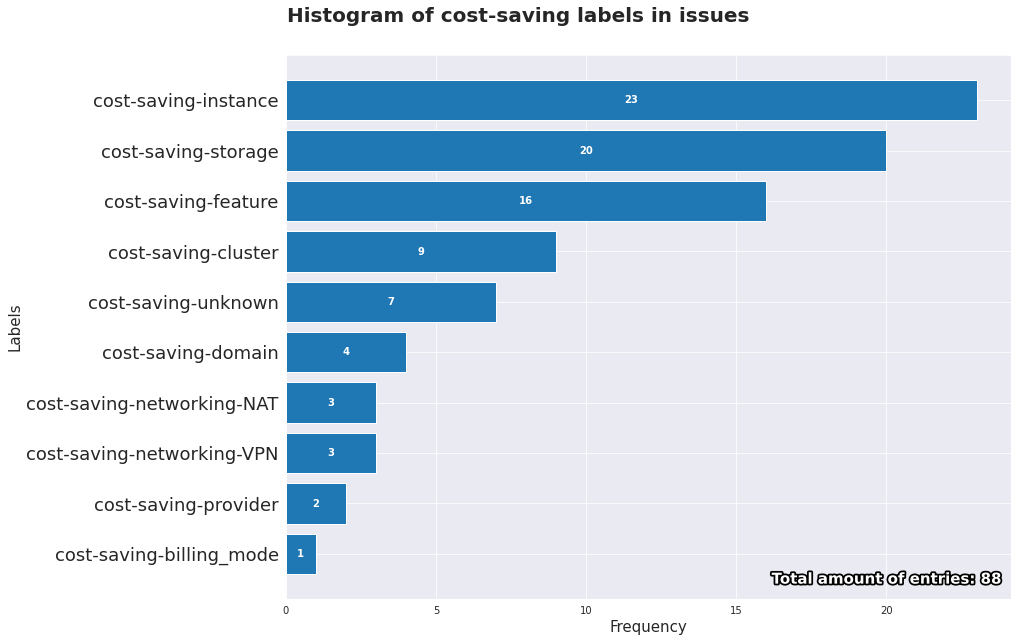

In [14]:
hist_saving = dict(sorted(hist_saving.items(), key=lambda item: item[1]))
figure, ax = plt.subplots(figsize=(13,10))
ax.barh(list(hist_saving.keys()), width=hist_saving.values())

plt.title("Histogram of cost-saving labels in issues", fontsize= 20, fontweight='bold', x=0.32, y=1.05)
plt.ylabel("Labels")
plt.xlabel("Frequency")

axes = plt.gca()
axes.yaxis.label.set_size(15)
axes.xaxis.label.set_size(15)

plt.tick_params(axis='y', labelsize=18)

for bar, label in zip(ax.patches, list(hist_saving.values())):
    plt.text(bar.get_width()/2, bar.get_y()+bar.get_height()/2, label, color = 'white', ha = 'center', va = 'center', fontweight='bold') 

txt = ax.text(20, -0.5, "Total amount of entries: 88", color = 'white', ha = 'center', va = 'center', fontweight='bold', fontsize= 15)
txt.set_path_effects([pe.withStroke(linewidth=3.5, foreground='black')])

plt.savefig('issues-cost-saving-hist.png', bbox_inches='tight')

plt.show()

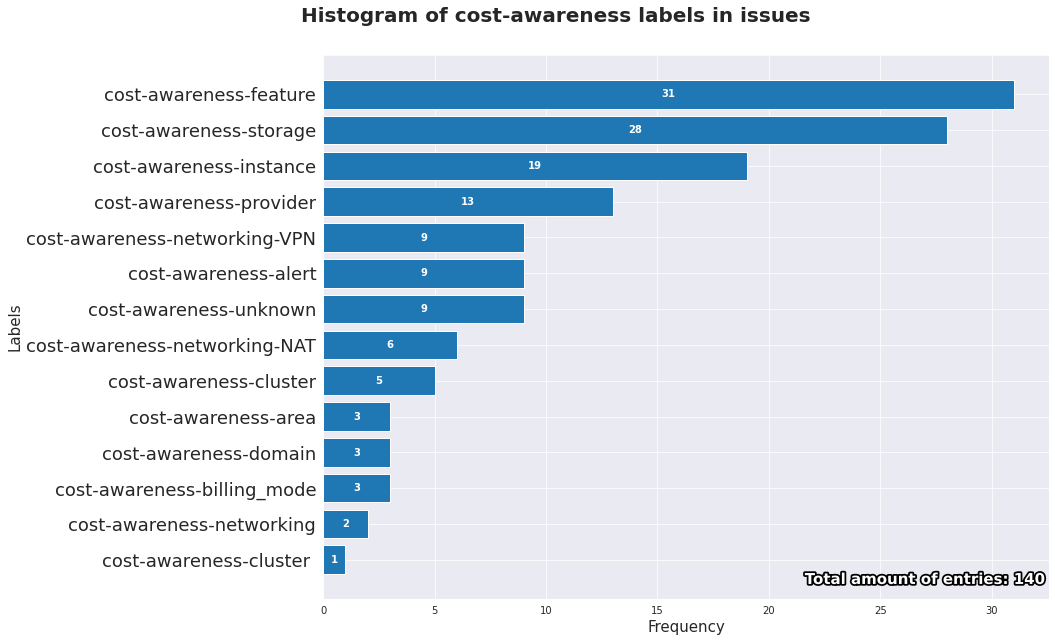

In [15]:
hist_awareness = dict(sorted(hist_awareness.items(), key=lambda item: item[1]))
figure, ax = plt.subplots(figsize=(13,10))
ax.barh(list(hist_awareness.keys()), width=hist_awareness.values())

plt.title("Histogram of cost-awareness labels in issues", fontsize= 20, fontweight='bold', x=0.32, y=1.05)
plt.ylabel("Labels")
plt.xlabel("Frequency")

axes = plt.gca()
axes.yaxis.label.set_size(15)
axes.xaxis.label.set_size(15)

plt.tick_params(axis='y', labelsize=18)

for bar, label in zip(ax.patches, list(hist_awareness.values())):
    plt.text(bar.get_width()/2, bar.get_y()+bar.get_height()/2, label, color = 'white', ha = 'center', va = 'center', fontweight='bold') 

txt = ax.text(27, -0.55, "Total amount of entries: 140", color = 'white', ha = 'center', va = 'center', fontweight='bold', fontsize= 15)
txt.set_path_effects([pe.withStroke(linewidth=3.5, foreground='black')])

plt.savefig('issues-cost-awareness-hist.png', bbox_inches='tight')

plt.show()

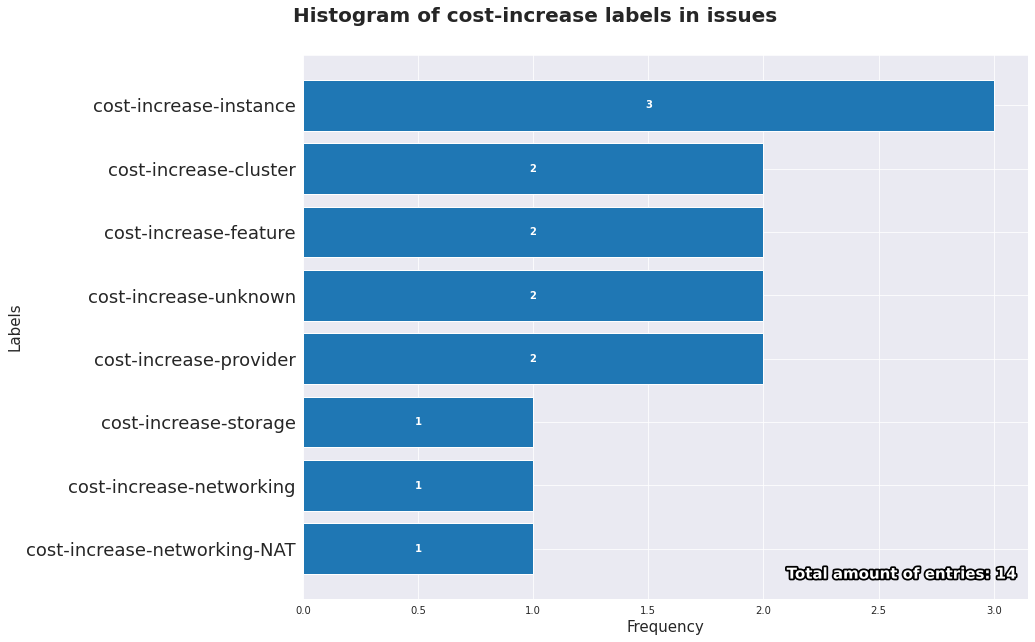

In [16]:
hist_increase = dict(sorted(hist_increase.items(), key=lambda item: item[1]))
figure, ax = plt.subplots(figsize=(13,10))
ax.barh(list(hist_increase.keys()), width=hist_increase.values())

plt.title("Histogram of cost-increase labels in issues", fontsize= 20, fontweight='bold', x=0.32, y=1.05)
plt.ylabel("Labels")
plt.xlabel("Frequency")

axes = plt.gca()
axes.yaxis.label.set_size(15)
axes.xaxis.label.set_size(15)

plt.tick_params(axis='y', labelsize=18)

for bar, label in zip(ax.patches, list(hist_increase.values())):
    plt.text(bar.get_width()/2, bar.get_y()+bar.get_height()/2, label, color = 'white', ha = 'center', va = 'center', fontweight='bold') 

txt = ax.text(2.6, -0.4, "Total amount of entries: 14", color = 'white', ha = 'center', va = 'center', fontweight='bold', fontsize= 15)
txt.set_path_effects([pe.withStroke(linewidth=3.5, foreground='black')])

plt.savefig('issues-cost-increase-hist.png', bbox_inches='tight')

plt.show()

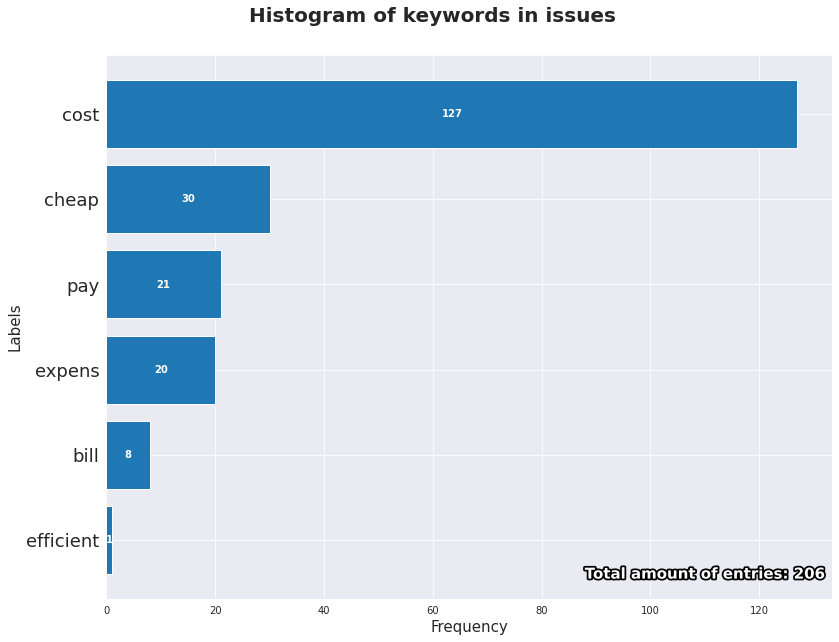

In [17]:
keyword_hist_cost = dict(sorted(keyword_hist_cost.items(), key=lambda item: item[1]))
figure, ax = plt.subplots(figsize=(13,10))
ax.barh(list(keyword_hist_cost.keys()), width=keyword_hist_cost.values())

plt.title("Histogram of keywords in issues", fontsize= 20, fontweight='bold', x=0.45, y=1.05)
plt.ylabel("Labels")
plt.xlabel("Frequency")

axes = plt.gca()
axes.yaxis.label.set_size(15)
axes.xaxis.label.set_size(15)

plt.tick_params(axis='y', labelsize=18)

for bar, label in zip(ax.patches, list(keyword_hist_cost.values())):
    plt.text(bar.get_width()/2, bar.get_y()+bar.get_height()/2, label, color = 'white', ha = 'center', va = 'center', fontweight='bold') 

txt = ax.text(110, -0.4, "Total amount of entries: 206", color = 'white', ha = 'center', va = 'center', fontweight='bold', fontsize= 15)
txt.set_path_effects([pe.withStroke(linewidth=3.5, foreground='black')])

plt.savefig('issues-histogram-keywords.png', bbox_inches='tight')

plt.show()

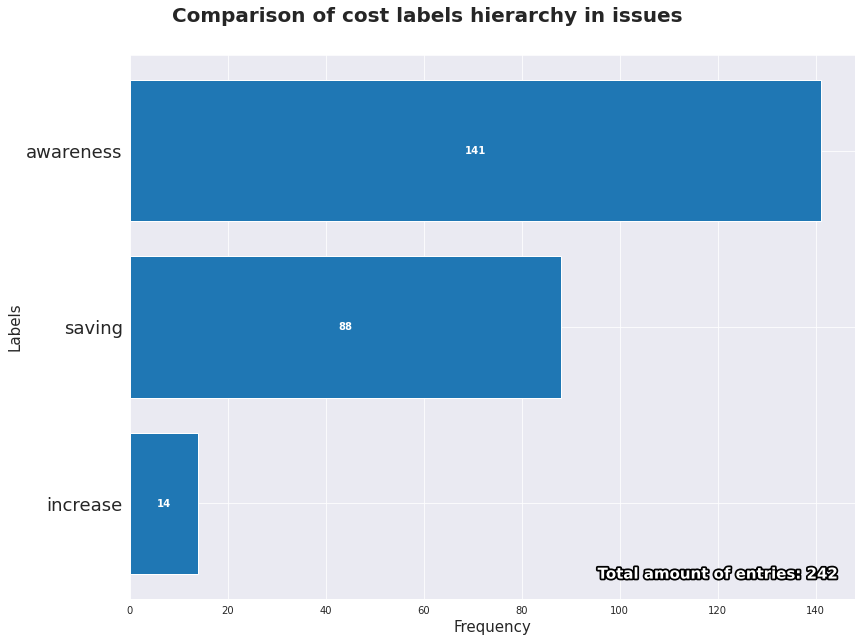

In [18]:
cost_label_dic = {"saving": saving_count, "awareness": awareness_count, "increase": increase_count}
cost_label_dic = dict(sorted(cost_label_dic.items(), key=lambda item: item[1]))
figure, ax = plt.subplots(figsize=(13,10))
ax.barh(list(cost_label_dic.keys()), width=cost_label_dic.values())

plt.title("Comparison of cost labels hierarchy in issues", fontsize= 20, fontweight='bold', x=0.41, y=1.05)
plt.ylabel("Labels")
plt.xlabel("Frequency")

axes = plt.gca()
axes.yaxis.label.set_size(15)
axes.xaxis.label.set_size(15)

plt.tick_params(axis='y', labelsize=18)

for bar, label in zip(ax.patches, list(cost_label_dic.values())):
    plt.text(bar.get_width()/2, bar.get_y()+bar.get_height()/2, label, color = 'white', ha = 'center', va = 'center', fontweight='bold') 

txt = ax.text(120, -0.4, "Total amount of entries: 242", color = 'white', ha = 'center', va = 'center', fontweight='bold', fontsize= 15)
txt.set_path_effects([pe.withStroke(linewidth=3.5, foreground='black')])

plt.savefig('issues-cost-hierarchy-comparison.png', bbox_inches='tight')

plt.show()

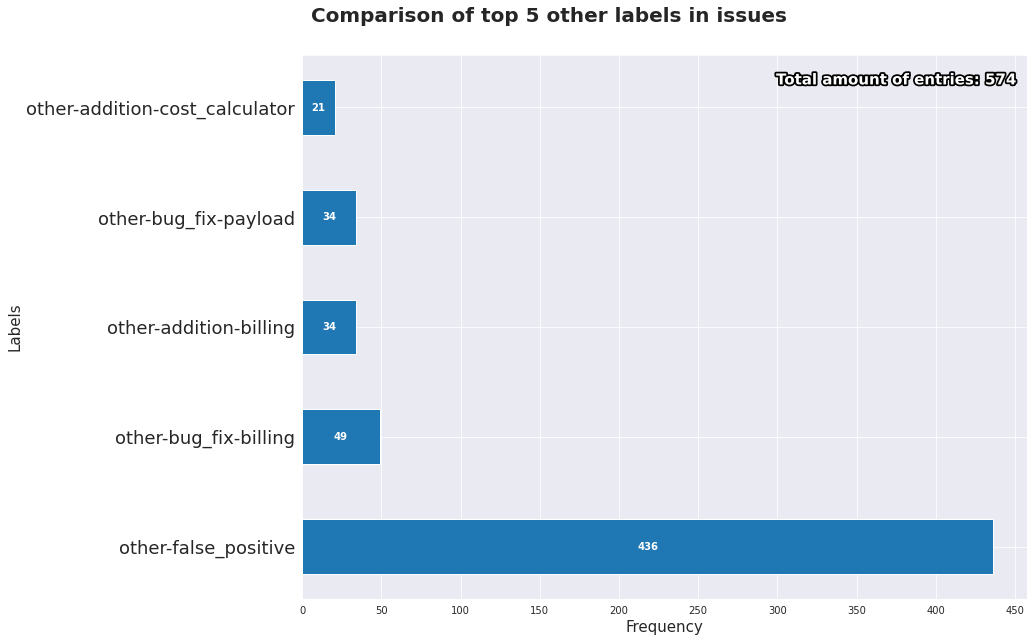

In [24]:
labels = []
values = []
count = 0
hist_other = dict(sorted(hist_other.items(), key=lambda item: -item[1]))
for item in hist_other.items():
    if count == 5:
        break
    labels.append(item[0])
    values.append(item[1])
    count += 1

x = np.arange(0, 451, 50)
figure, ax = plt.subplots(figsize=(13,10))
ax.barh(labels, width=values, height=.5)
plt.xticks(x)
plt.title("Comparison of top 5 other labels in issues", fontsize= 20, fontweight='bold', x=0.34, y=1.05)
plt.ylabel("Labels")
plt.xlabel("Frequency")


figure.patch.set_facecolor('white')

axes = plt.gca()
axes.yaxis.label.set_size(15)
axes.xaxis.label.set_size(15)

plt.tick_params(axis='y', labelsize=18)

for bar, label in zip(ax.patches, values):
    plt.text(bar.get_width()/2, bar.get_y()+bar.get_height()/2, label, color = 'white', ha = 'center', va = 'center', fontweight='bold')

txt = ax.text(375, 4.25, f"Total amount of entries: {sum(values)}", color = 'white', ha = 'center', va = 'center', fontweight='bold', fontsize= 15)
txt.set_path_effects([pe.withStroke(linewidth=3.5, foreground='black')])

plt.savefig('other-5label-comparison_issues.png', bbox_inches='tight')
plt.show()